In [1]:
from avcv.utils import *

In [2]:
from avcv.visualize import *
import mmcv
from avcv.debug import *
import numpy as np
class VisualizeCoco:
    def __init__(self, gt, img_dir, pred=None):
        if isinstance(gt, str):
            from pycocotools.coco import COCO
            gt = COCO(gt)
        if isinstance(pred, str):
            pred = gt.loadRes(mmcv.load(pred))

        self.gt = gt
        self.pred = pred
        self.img_dir = img_dir
        self.img_ids = [_['id'] for _ in gt.imgs.values()]

    def visualize(self, img_id, verbose=True, zoom=False, mode='pred'):
#         assert self.pred is not None
        gt = self.gt
        pred = self.gt
        CLASSES = [_['name'] for _ in self.gt.dataset['categories']]
        im = gt.imgs[img_id]
        source = pred if mode == 'pred' else gt
        anns = source.loadAnns(source.getAnnIds(im['id']))
        ann_ids = source.getAnnIds(im['id'])
        if verbose:
            print('Num of bboxes:', len(ann_ids))
        bb_preds  = source.loadAnns(ann_ids)

        det_bboxes = []
        lables = []
        for bb_pred in bb_preds:
            x1,y1,w,h = bb_pred['bbox']
            x2 = x1+w
            y2 = y1+h
            det_bboxes.append([x1,y1,x2,y2, bb_pred.get('score', 1)])
            lables.append(bb_pred['category_id'])

        det_bboxes = np.array(det_bboxes)
        lables = np.array(lables)
        img = mmcv.imread(self.img_dir+im['file_name'], channel_order='rgb')
        img = mmcv.visualization.imshow_det_bboxes(img, det_bboxes, lables, CLASSES, show=False)
        return img
    
def draw_3d_box(img, vertices, label, colour=(255,128,128), draw_2d_bounding_box=False):
    """Draw a 3D bounding from a given 3D label on a given "img". "vehicle_to_image" must be a projection matrix from the vehicle reference frame to the image space.

    draw_2d_bounding_box: If set a 2D bounding box encompassing the 3D box will be drawn
    """
    import cv2

#     vertices = get_3d_box_projected_corners(vehicle_to_image, label)
#     if vertices is None:
        # The box is not visible in this image
#         return
    
    if draw_2d_bounding_box:
        x1,y1,x2,y2 = compute_2d_bounding_box(img.shape, vertices)

        if (x1 != x2 and y1 != y2):
            cv2.rectangle(img, (x1,y1), (x2,y2), colour, thickness = 1)
    else:
        # Draw the edges of the 3D bounding box
        for k in [0, 1]:
            for l in [0, 1]:
                for idx1,idx2 in [((0,k,l),(1,k,l)), ((k,0,l),(k,1,l)), ((k,l,0),(k,l,1))]:
                    v1,v2 = tuple(vertices[idx1]), tuple(vertices[idx2])
                    cv2.line(img, v1,v2, colour, thickness=1)
        # Draw a cross on the front face to identify front & back.
        # points = []
        
        
        
        for idx1,idx2 in [((1,0,0),(1,1,1)), ((1,1,0),(1,0,1))]:
            cv2.line(img, tuple(vertices[idx1]), tuple(vertices[idx2]), colour, thickness=1)
    return img

In [3]:
coco = VisualizeCoco('./data/annotations/train_segment-1071392229495085036_1844_790_1864_790_with_camera_labels.json', './data/images/')

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: './data/annotations/train_segment-1071392229495085036_1844_790_1864_790_with_camera_labels.json'

In [163]:
# %debug

In [164]:
ds = coco.gt

In [165]:
# img

In [187]:
def get_bbox_2d(bbox_on_2d):
    xmin = bbox_on_2d[...,0].min()
    xmax = bbox_on_2d[...,0].max()
    ymin = bbox_on_2d[...,1].min()
    ymax = bbox_on_2d[...,1].max()
    return np.array([xmin, ymin, xmax,ymax])

def get_depth_in_box(depth, bbox):
    xmin, ymin, xmax,ymax = bbox
    values = []
    for x,y,v in depth:
        if x>xmin and x<xmax and y>ymin and y<ymax:
            values.append(v)
    return values

In [188]:
image = ds.loadImgs(0)[0]
bboxes = ds.loadAnns(ds.getAnnIds(0))
img = mmcv.imread('./data/images/'+image['file_name'])[...,::-1].astype('uint8')
depth = np.load('./data/depth/'+image['file_name'].replace('.jpg', '.npy'))

In [191]:
pred_depths = cv2.imread('1 (1).png', 0)

In [193]:
# pred_depths.shape

In [194]:

depths = []
for ann in bboxes:
    bbox = ann['bbox_3d']
    if bbox is not None:
        bbox = np.array(bbox)
        bbox[...,0]/=bbox[...,-1]
        bbox[...,1]/=bbox[...,-1]
        
        dis = bbox[...,2]
        bde = np.mean(dis)
        bbox_on_2d = bbox[...,:2].astype(int)
        bbox_2d = get_bbox_2d(bbox_on_2d)
        de = get_depth_in_box(depth, bbox_2d)
        
        img = draw_3d_box(img, bbox_on_2d, ann['category_id'])
        de = np.mean(de)
        
        x1,y1,x2,y2 = bbox_2d
        pred_de = pred_depths[y1:y2, x1:x2].mean()
        depths.append([de,pred_de])
        
        img = put_text(img, (bbox_2d[0], bbox_2d[1]),  f'{de:0.2f} - {bde:0.2f} m', color=(255,0,0))

<ipython-input-194-60f0dd2d232b>:19: RuntimeWarning: Mean of empty slice.
  pred_de = pred_depths[y1:y2, x1:x2].mean()
/home/av/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/av/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [216]:
def depth_to_mask(im_or_shape, depth):
    if isinstance(im_or_shape, np.ndarray):
        shape = im_or_shape.shape[:2]
    else:
        shape = im_or_shape[:2]
    if isinstance(depth, str):
        depth = np.load(depth)
    
    mask = np.zeros(shape)
    for x,y,v in depth:
        if x < shape[1] and y < shape[0]:
            x = int(x)
            y = int(y)
            mask[y,x] = v
    return mask

In [217]:
img_path = './data/images/segment-11037651371539287009_77_670_97_670_with_camera_labels_1_0.jpg'
depth_path = img_path.replace('/images/', '/depth/').replace('.jpg', '.npy')

In [219]:
img = mmcv.imread(img_path, channel_order='rgb')
depth_mask = depth_to_mask(img, depth_path)

In [230]:
show(depth_mask, cmap='inferno', out_file='test.jpg')

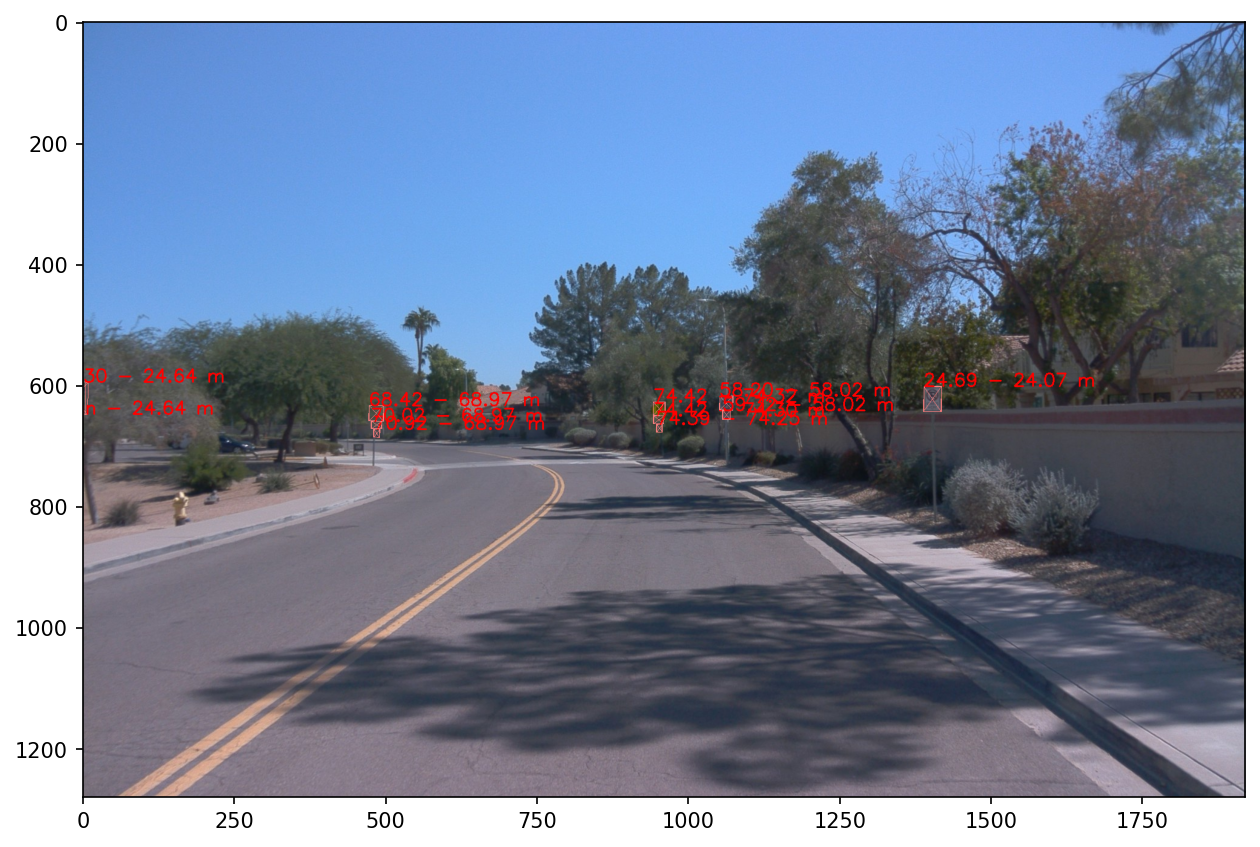

In [190]:
show(img, dpi=150)

In [204]:
ds.dataset['annotations'][0]

{'bbox_3d': [[[[69934.59590576986, 49258.95459566364, 74.25748098680862],
    [69946.90268779965, 48309.5970051557, 74.26216977937126]],
   [[71323.28309236812, 49374.215006360784, 74.41584917961484],
    [71335.5898743979, 48424.85741585284, 74.42053797217748]]],
  [[[69903.72109981801, 49209.214161611926, 74.18202695170702],
    [69916.0278818478, 48259.856571103985, 74.18671574426966]],
   [[71292.40828641626, 49324.47457230907, 74.34039514451324],
    [71304.71506844605, 48375.116981801126, 74.34508393707588]]]],
 'image_id': 0,
 'category_id': 3,
 'id': 0}